# Analyze Eye Gaze Data

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pickle
from statsmodels.robust.scale import mad

import matplotlib.pyplot as plt

In [21]:
a = pd.read_csv('adhd_eye_movement_data/user_info.csv')
a.iloc[a.index[a['Subject'] == 3][0]]['Group']

'off-ADHD'

In [22]:
def load_raw_data(subject_num):
    data_dir = 'adhd_eye_movement_data/'
    raw_data_dir = data_dir + 'raw_data/'
    user_info_df = pd.read_csv(data_dir + 'user_info.csv')

    user_info_df_subj = user_info_df['Subject']
    data = pd.DataFrame()

    # If off-ADHD/on-ADHD subject:
    if user_info_df_subj.value_counts()[subject_num] == 2:
        data = pd.read_csv("{}/subject_{}_off_ADHD.csv".format(raw_data_dir, subject_num))
    elif user_info_df_subj.value_counts()[subject_num] == 1:
        group = user_info_df.iloc[user_info_df.index[user_info_df['Subject'] == subject_num][0]]['Group']

        if group == 'off-ADHD':
            data = pd.read_csv("{}/subject_{}_off_ADHD.csv".format(raw_data_dir, subject_num))
        elif group == 'Ctrl':
            data = pd.read_csv("{}/subject_{}_Ctrl.csv".format(raw_data_dir, subject_num))
    else:
        return -1

    data = data.dropna(subset=['Time']).set_index('Time')
    data.index = data.index.astype(int)
    
    return data

def extract_trials(raw_data):
    trials = []
    for idx, row in raw_data[raw_data['Events'] == 7].iterrows():
        # Find start of trial
        start_interval = raw_data.loc[idx-5250:idx-4250]
        end_interval = raw_data.loc[idx:idx+4000]
        
        start_idx = idx - 4750
        if 1 in start_interval['Events'].values:
            assert start_interval['Events'].value_counts()[1] == 1

            start_idx = start_interval.index[start_interval['Events'] == 1].to_list()[0]
        elif 2 in start_interval['Events'].values:
            assert start_interval['Events'].value_counts()[2] == 1

            start_idx = start_interval.index[start_interval['Events'] == 2].to_list()[0]
        
        trials.append(raw_data.loc[start_idx:start_idx+7999].to_numpy())
    
    return trials

In [26]:
test = load_raw_data(16)
test

,Diameter,Position_1,Position_2,Events
Time,,,,
2585947,10998.0,926.8,512.0,0
2585948,11002.0,926.6,511.5,0
2585949,11004.0,926.7,511.7,0
2585950,11007.0,926.6,512.2,0
2585951,11006.0,926.5,512.6,0
...,...,...,...,...
4946164,6659.0,942.7,629.7,0
4946165,6656.0,942.8,628.8,0
4946166,6653.0,942.8,629.1,0


In [29]:
test_trials = extract_trials(test)
test_trials

[array([[6.986e+03, 8.942e+02, 5.585e+02, 1.000e+00],
        [6.986e+03, 8.940e+02, 5.585e+02, 0.000e+00],
        [6.984e+03, 8.939e+02, 5.585e+02, 0.000e+00],
        ...,
        [6.969e+03, 8.894e+02, 6.154e+02, 0.000e+00],
        [6.971e+03, 8.895e+02, 6.148e+02, 0.000e+00],
        [6.972e+03, 8.895e+02, 6.151e+02, 0.000e+00]]),
 array([[7.010e+03, 8.895e+02, 6.155e+02, 1.000e+00],
        [7.011e+03, 8.895e+02, 6.153e+02, 0.000e+00],
        [7.011e+03, 8.893e+02, 6.153e+02, 0.000e+00],
        ...,
        [7.870e+03, 8.496e+02, 6.251e+02, 0.000e+00],
        [7.870e+03, 8.496e+02, 6.251e+02, 0.000e+00],
        [7.871e+03, 8.497e+02, 6.253e+02, 0.000e+00]]),
 array([[6.948e+03, 9.016e+02, 6.289e+02, 2.000e+00],
        [6.948e+03, 9.015e+02, 6.290e+02, 0.000e+00],
        [6.948e+03, 9.015e+02, 6.291e+02, 0.000e+00],
        ...,
        [6.589e+03, 8.945e+02, 5.986e+02, 0.000e+00],
        [6.591e+03, 8.944e+02, 5.986e+02, 0.000e+00],
        [6.592e+03, 8.948e+02, 5.985e+0

In [33]:
test_trials[0][:, 3]

array([1., 0., 0., ..., 0., 0., 0.])

# Data Preprocessing

## Heuristic Spike Filter + Signal Loss + Noise Reduction

In [34]:
from eye_gaze_analysis import *

clf = EyegazeClassifier()

data = {'x': test_trials[0][:, 1], 'y': test_trials[0][:, 2]}

In [36]:
events = clf(clf.preproc(data))
events

[{'id': None,
  'label': 'FIXA',
  'start_time': 0.0,
  'end_time': 0.273,
  'start_x': 893.9581425478756,
  'start_y': 558.3191131078457,
  'end_x': 898.7718553023394,
  'end_y': 567.2236435327004,
  'amp': 0.10122375836218012,
  'peak_vel': 2.666259052941302,
  'med_vel': 0.9110387399430208,
  'avg_vel': 0.9825549365837203},
 {'id': 1,
  'label': 'SACC',
  'start_time': 0.273,
  'end_time': 0.314,
  'start_x': 898.9730319176819,
  'start_y': 567.4863128631017,
  'end_x': 885.4325179705352,
  'end_y': 667.1334736404004,
  'amp': 1.005629264139111,
  'peak_vel': 57.838036962301814,
  'med_vel': 23.20505098122808,
  'avg_vel': 26.700388733874338},
 {'id': None,
  'label': 'PURS',
  'start_time': 0.314,
  'end_time': 0.438,
  'start_x': 885.329031961499,
  'start_y': 667.0084730193275,
  'end_x': 879.5081795990451,
  'end_y': 670.1230703263946,
  'amp': 0.0660174511857847,
  'peak_vel': 3.646658481647166,
  'med_vel': 1.2436244825835354,
  'avg_vel': 1.2887895041380177},
 {'id': None,
  

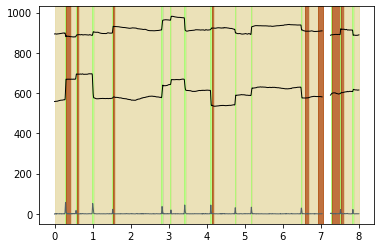

In [40]:
clf.show_gaze(pp=clf.preproc(data), events=events)

In [ ]:
filtered_x = heuristic_spike_filter(raw_x)
plt.plot(filtered_x)

In [ ]:
filtered_y = heuristic_spike_filter(raw_y)
plt.plot(filtered_y)

In [ ]:
# Euclidean distance
# Input: (x1, y1), (x2, y2)
def euclidean_dist(point1, point2):
    return np.sqrt(np.square(point1[0] - point2[0]) + np.square(point1[1] - point2[1]))

# Point-to-point velocity
# Input: (x1, y1), (x2, y2)
def ptp_velocity(point1, point2, t1, t2):
    return euclidean_dist(point1, point2) / (t2 - t1)

# Point-to-point velocities for a given interval
# Input: df 
def ptp_velocities(data):
    velocities = []
    for idx, row in data.iterrows():
        if idx + 1 < len(data):
            pass

print(euclidean_dist(5, 0, 100, 0))
print(ptp_velocity(5, 0, 100, 0, 5, 10))

# Scanpath Analysis

In [ ]:
plt.plot(test['Position_1'], test['Position_2'])

In [ ]:
plt.plot(fetch_data(45)['Position_1'], fetch_data(45)['Position_2'])

In [ ]:
test.where(test['Events'])